# Исследование рынка общественного питания Москвы

Задача: при помощи набора данных о московском общепите нужно составить список рекомендаций начинающему бизнесмену, который планирует открыть небольшое кафе, и подготовить презентацию для инвесторов.

### Загрузка и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import requests
import io

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
data.number.describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [5]:
data.sample(10)

,id,object_name,chain,object_type,address,number
10017,171815,Лето близко,нет,кафе,"город Москва, Цветной бульвар, дом 26, строение 1",50
11056,182665,HAMM'S FOOD,нет,кафе,"город Москва, улица Сущёвский Вал, дом 5, стро...",30
9446,163276,Wine and dine,нет,кафетерий,"город Москва, Новинский бульвар, дом 7",30
6535,23785,КП МГУ столовая 4 2,нет,столовая,"город Москва, территория Ленинские Горы, дом 1",82
5133,27951,Столовая,нет,столовая,"город Москва, Новгородская улица, дом 1",90
11575,173455,VOGoo,нет,предприятие быстрого обслуживания,"город Москва, Каширское шоссе, дом 26",4
12064,183252,Иль Патио,да,ресторан,"город Москва, Дмитровское шоссе, дом 163А, кор...",60
4703,29167,ГБОУ Коллежд связи №54,нет,столовая,"город Москва, Рабочая улица, дом 12, строение 1",150
2762,27035,АЛЬПИЙСКИЙ ДВОРИК,нет,ресторан,"город Москва, Дмитровское шоссе, дом 27, корпус 1",70
8241,21887,Кофемания,да,кафе,"город Москва, Трубная площадь, дом 2",70


Пропусков нет, типы данных везде подходящие (разве что `chain` можно было бы привести к булеву типу, но задача экономить память не стоит, так что делать этого не будем).

Краевые значения в `number` на первый взгляд похожи на ошибочные, но если присмотреться, оказывается, что нули в этом столбце соответствуют либо стоячим кафе, либо заведениям, которые продают еду на вынос или с доставкой, а места с неправдоподобно большим количеством посадочных мест действительно существуют (это банкетные залы, столовые при крупных учреждениях, просто большие клубы и рестораны).

В `object_name` ожидаемый разнобой в написании названий и адресов. В этом столбце наверняка есть дубликаты, но выявить их на этапе предобработки данных не получится (не считая проверки приведением к нижнему регистру). Поэтому ограничимся тем, что после группировки по названиям заведений посмотрим хотя бы на наиболее крупные сети.

Названия категорий в `object_type` и `chain` понятные и их немного.

In [6]:
data.drop_duplicates(inplace=True)
data.shape[0]

15366

Полных дубликатов нет. Посмотрим, нет ли строк, которые отличаются только `id` и/или количеством посадочных мест -- такие значения могли появиться в датасете на этапе выгрузки или сбора данных.

In [7]:
clean = data.loc[:, ~data.columns.isin(['id', 'number'])].drop_duplicates()
clean.shape[0]

15196

170 строк. Сценариев, при которых они окажутся легитимными, нет, так что запишем очищенный датасет в ту же переменную.

In [8]:
data = data.loc[data.index.isin(clean.index)]

Теперь нужно избавиться от дубликатов в `object_name`. Под дубликатами будем понимать случаи, когда одно и то же заведение встречается под разными названиями. Например, "шоколадница" и "кафе шоколадница" или "старбакс", "starbucks" и "STARBUCKS".

В категории не-сетевых заведений дубликаты искать бессмысленно: там будет множество незамысловатых названий типа "Столовая" и "Кафе", и то, что они повторяются, никак не скажется на статистике. А вот если дубликаты останутся среди сетевых заведений, мы рискуем получить неправильное представление об их распределении по численности точек и другим показателям.

Сначала приведем все названия к нижнему регистру и удалим знаки препинания и лишние пробелы, если они есть, а также вручную транслитерируем несколько наиболее частых названий -- это позволит отсеять часть дубликатов. 

Затем сгруппируем сетевые заведения по названиям сети и отсортируем по убыванию, результата запишем в переменную `chains`.

In [9]:
# посмотрим на список наиболее често встречающихся названий, в которых используется ллатиница:
data.query('chain == "да" and object_name.str.contains("[A-z]")')\
.groupby('object_name')['id'].count().sort_values(ascending=False)

object_name
KFC                                 155
Суши Wok                             61
Starbucks                            29
Subway                               29
Мята Lounge                          23
Cofix                                22
СтардогS                             11
Кафе «KFC»                           11
Ростикс KFC                           7
Krispy Creme                          7
Бургер Кинг Burger King               7
ПРАВDА Кофе                           6
Dunkin Donuts                         6
Wok & Box                             5
SUBWAY                                5
Costa Coffee                          5
Суши WOK                              5
MosKalyan                             5
Prime Прайм стар                      4
Osteria Mario                         4
Jeffreys coffee                       4
Coffeeshop Company                    4
СУШИ WOK                              4
Стардогs                              3
Bocconcino                  

In [10]:
data.object_name = data.object_name.str.lower()\
.replace('[^\w\s]+', ' ', regex=True)\
.apply(lambda x: ' '.join(x.split()))

data.object_name = data.object_name.replace({'subway': 'сабвей', 
                                             'starbucks': 'старбакс',
                                             'lounge': 'лаунж',
                                             'pizza hut': 'пицца хат',
                                             'kitchen': 'китчен',
                                             'prime': 'прайм'}, regex=True)

chains = data.query('chain == "да"').groupby('object_name')['id'].count().sort_values(ascending=False).reset_index()

print(chains.to_string())

                                           object_name   id
0                                          шоколадница  155
1                                                  kfc  155
2                                           макдоналдс  148
3                                          бургер кинг  136
4                                              теремок   94
5                                      крошка картошка   90
6                                       домино с пицца   90
7                                                милти   72
8                                             суши wok   72
9                                               сабвей   53
10                                          папа джонс   51
11                                            старбакс   50
12                                          додо пицца   49
13                                        кофе с собой   43
14                                           чайхона 1   42
15                                      

В верхней части списка оказались самые частотные и, что важно, самые краткие варианты названий самых многочисленных сетей. Просматривая список дальше, мы видим, что оставшиеся дубликаты в основном связаны с тем, что люди, вводившие данные, иногда указывали краткое название, а иногда более развернутое: например, "кафе "шоколадница"" вместо "шоколадница". 

Чтобы исключить такие дубликаты, с помощью цикла сравним каждую строку в `chains` cо всеми остальными и выделим такие пары строк, что значение `object_name` одной из них включает в себя значение в этом же столбце другой. Затем из этих двух значений выберем то, которому соответствует большее значение `id`, и присвоим его `object_name` другой строки через словарь `replacement`. Словарь для контроля выведем на экран.

Это неидеальный механизм (работа цикла занимает много времени, некоторые значения присваиваются ошибочно), но он наиболее универсален и дает наилучшие результаты из всех опробованных. Поскольку нас интересует общая картина, а не статистика по каждой сети в отдельности, ошибками можно пренебречь.

In [11]:
chains['short_name'] = chains['object_name']
for index, value in chains.iterrows():
    chains.loc[(chains['short_name'].str.contains(value['object_name'])) &\
               (chains['id'] <= value['id']), 'short_name'] = value['short_name']
replacement = pd.Series(chains.short_name.values, index=chains.object_name).to_dict()

# медленный вариант:
# replacement = {}

# for i in range(chains.shape[0]):
#     for j in range(chains.shape[0]):
#         if (i!= j)\
#         & (chains.loc[i]['object_name'] in chains.loc[j]['object_name'])\
#         & (chains.loc[i]['id'] >= chains.loc[j]['id']):
#             replacement.update({chains.loc[j]['object_name']: chains.loc[i]['object_name']})

replacement

По словарю видно, что переименование в некоторых случаях занимает больше одной итерации, так что повторим его трижды.

In [12]:
data.object_name.replace(replacement, inplace=True)
# data.object_name.replace(replacement, inplace=True)
# data.object_name.replace(replacement, inplace=True)

data.query('chain == "да"').groupby('object_name')['id'].count().sort_values(ascending=False).reset_index()

,object_name,id
0,kfc,187
1,шоколадница,180
2,макдоналдс,170
3,бургер кинг,158
4,теремок,111
5,домино с пицца,99
6,крошка картошка,96
7,милти,81
8,суши wok,76
9,старбакс,68


Количество уникальных названий сетей сократилось вдвое по сравнению с тем, с которого начинали.


### Анализ данных

**Построим график количества заведений разных типов.**

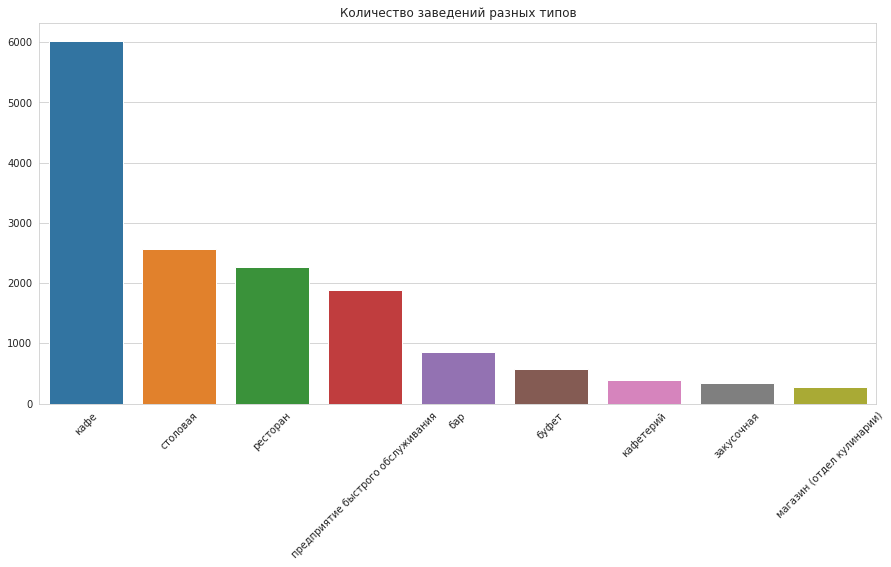

In [13]:
plt.figure(figsize=(15,7))
sns.set_style('whitegrid')
ax = sns.countplot(x='object_type', data=data, order=data.object_type.value_counts().index)
ax.set_title('Количество заведений разных типов')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=45)
plt.show()

По типу среди заведений больше всего кафе, также довольно много столовых, ресторанов и предприятий быстрого обслуживания, а все остальные категории представлены значительно хуже.

**Каковы в нашей выборке доли сетевых и несетевых заведений?**

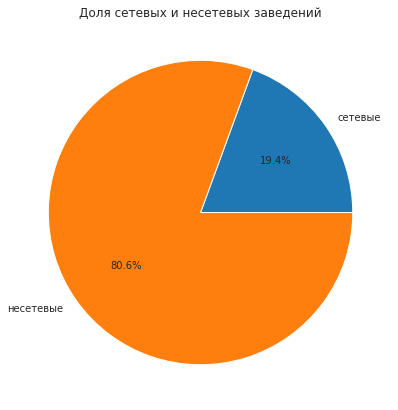

In [14]:
chain_prop = data.groupby('chain')['id'].count()

fig, test = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
test.set_title('Доля сетевых и несетевых заведений')
plt.pie(chain_prop, labels=['сетевые', 'несетевые'], autopct='%1.1f%%')
plt.show()

В московском общепите доминируют несетевые заведения, их около 81%.

**Что можно сказать о распределении по типам среди сетевых заведений?**

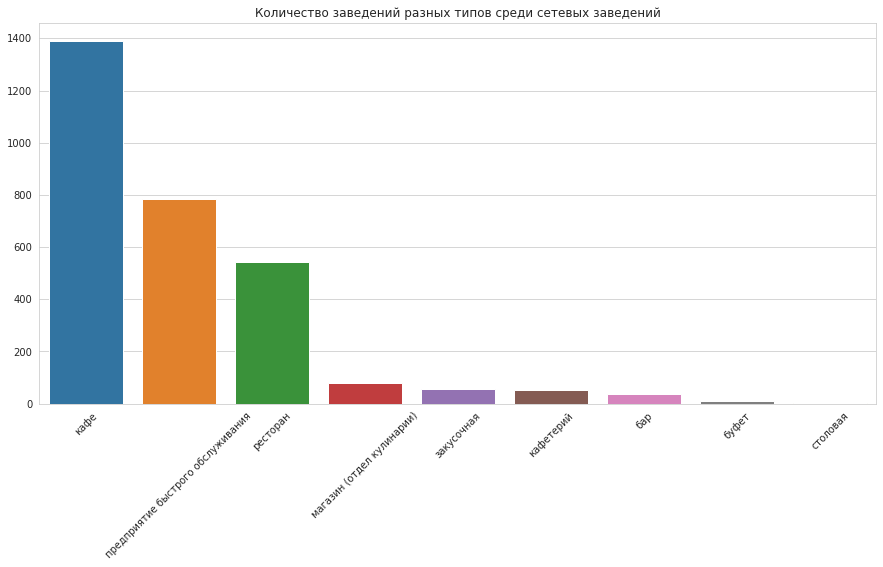

In [15]:
ch_types = data.query('chain == "да"')

plt.figure(figsize=(15,7))
ax = sns.countplot(x='object_type', data=ch_types, order=ch_types.object_type.value_counts().index)
ax.set_title('Количество заведений разных типов среди сетевых заведений')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=45)
plt.show()

На первом месте по-прежнему кафе, а на третьем -- рестораны. На втором месте оказались предприятия быстрого обслуживания, они вытеснили столовые. Доля всех остальных видов общепита значительно меньше.

**Что характерно для сетевых заведений:** много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

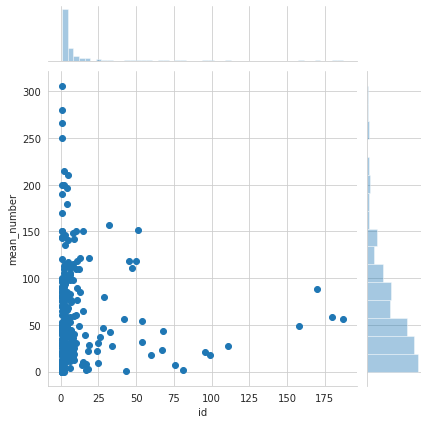

In [16]:
chain_data = data.query('chain == "да"')\
.groupby('object_name')\
.agg({'id': 'count', 'number': 'sum'}) # аггрегируем сетевые заведения по количеству точек и посадочных мест в них

chain_data['mean_number'] = round(chain_data.number / chain_data.id, 1) # столбец со средним количеством мест на точку

sns.jointplot(x='id', y='mean_number', data=chain_data)

По этому графику видно, что преобладают небольшие сети -- как по количеству точек, так и по количеству мест в среднем на точку. Но по количеству мест распределение более плавное, так что из двух вариантов, между которыми предлагалось выбрать в задании, эта картина скорее соответствует второму.

Чтобы получить более точную оценку, применим функцию, которая отсекает выбросы и показывает, какая доля точек и посадочных мест приходится на те сети, которые укладываются в норму.

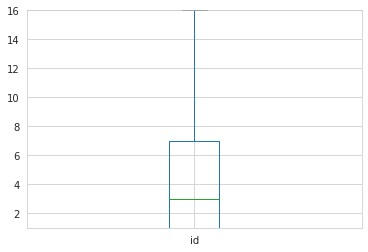

Нормальные значения: от 1 до 16.0
В пределах этой нормы находится:
-- 25.48% датасета по числу точек
-- 29.32% датасета по числу посадочных мест


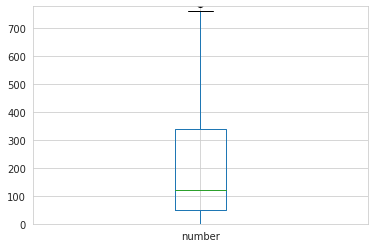

Нормальные значения: от 0 до 777.5
В пределах этой нормы находится:
-- 35.28% датасета по числу точек
-- 23.10% датасета по числу посадочных мест


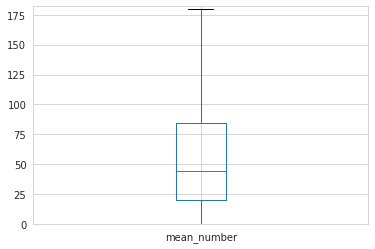

Нормальные значения: от 0 до 182.0
В пределах этой нормы находится:
-- 99.12% датасета по числу точек
-- 97.34% датасета по числу посадочных мест


,id,number,mean_number
object_name,,,
beverly hills diner,1,88,88.0
bierloga,1,75,75.0
black white,1,40,40.0
bocconcino,3,200,66.7
boobo,1,46,46.0
bubbleology,1,6,6.0
burger club,3,61,20.3
coffeeshop,2,85,42.5
coffeeshop company,4,189,47.2


In [17]:
def make_boxplot(df, labels):
    for label in labels:
        q1 = df[label].describe()['25%']
        q3 = df[label].describe()['75%']
        upper_whisker = q3 + 1.5*(q3 - q1)
        lower_whisker = q1 - 1.5*(q3 - q1)
        if lower_whisker < 0:
            lower_whisker = 0
        if lower_whisker < df[label].min():
            lower_whisker = df[label].min()
        
        df.boxplot(label)
        plt.ylim(lower_whisker, upper_whisker)
        plt.show()
        print('Нормальные значения: от', lower_whisker, 'до', upper_whisker)
        print('В пределах этой нормы находится:')
        print('-- {0:.2%} датасета по числу точек'.format(
            df.loc[(df[label] < upper_whisker) & (df[label] > lower_whisker)].id.sum() / chain_data.id.sum()))
        print('-- {0:.2%} датасета по числу посадочных мест'.format(
            df.loc[(df[label] < upper_whisker) & (df[label] > lower_whisker)].number.sum() / chain_data.number.sum()))    
    return df       

make_boxplot(chain_data, ['id', 'number', 'mean_number'])

В нормальной московской сети общественного питания не более 16 точек и суммарно не более 843 посадочных мест (медиана -- чуть менее 50 на точку). Но из расчетов видно, что определяет лицо московского общепита не эта норма, а немногочисленные выбросы -- гиганты вроде KFC, "Шоколадницы" и "Макдональдса", которые в норму совершенно не вписываются: по числу точек и посадочных мест они занимают 70-75% рынка.

Теперь изучим, **как отличаются разные типы заведений по среднему количеству посадочных мест.**

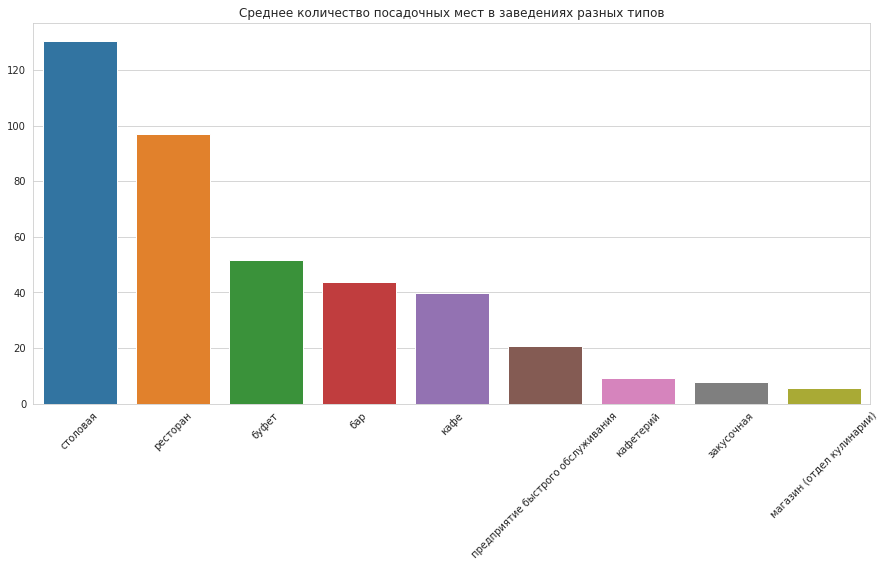

In [18]:
number_by_type = data.groupby('object_type')['number'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15,7))
ax = sns.barplot(x='object_type', y='number', data=number_by_type)
ax.set_title('Среднее количество посадочных мест в заведениях разных типов')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=45)
plt.show()

По количеству посадочных мест лидируют столовые (в среднем около 130 мест), за ними с отрывом примерно в 30 мест следуют рестораны, а все остальные типы заведений по этому параметру далеко позади. На третьем месте буфеты с примерно 30 посадочными местами на заведение.

Для дальнейшего анализа нам потребуется **столбец с названием улицы**, на которой располагается заведение. Создадим его при помощи функции `get_street` и небольшого дополнительного преобразования.

In [19]:
def get_street(row):
    if "Москва" in row and ("Зеленоград" in row or "поселение" in row):
        street = row.split(', ')[1] + ',' + row.split(',')[2]
    elif "Москва" not in row and ("Зеленоград" in row or "поселение" in row):
        street = row.split(', ')[0] + ',' + row.split(',')[1]
    elif "Москва" not in row:
        street = row.split(', ')[0]
    else:
        street = row.split(', ')[1]
    return street


data['street'] = data.address.apply(get_street)

Адреса в Зеленограде и поселениях новой Москвы пришлось обработать отдельно. 

Дело в том, что при разбиении обычных московских адресов на подстроки название улицы, которое мы хотим достать, как правило оказывается во второй подстроке -- но не в случае с Зеленоградом и поселениями, где название улицы или просто корпуса, как это принято в Зеленограде (https://www.zelenograd.ru/gid/kak-ustroen-zelenograd/), вытесняется в третью подстроку.

Если бы мы применили к Зеленограду и поселениям общую логику, мы бы лишились разбиения на улицы внутри них. В результате Зеленоград вышел бы на первое место по числу заведений общепита, отодвинув самые оживленные улицы Москвы, а это противоречит здравому смыслу.

Кроме того, в датасете есть адреса, где не указан город (подразумевается, что это Москва). Это обстоятельство тоже учтено при написании функции, иначе в стоблце `street` вместо названия улицы оказался бы номер дома.

Чтобы окончательно разобраться с Зеленоградом, нужно учесть следующее: в номерах корпусов из зеленоградских адресов совмещены номер микрорайона (то есть аналог названия улицы в остальной Москве) с номером дома. Чтобы статистика была достоверной, нужно отделить одно от другого и оставить только номер микрорайона -- ему соответствуют первая или первая и вторая цифры в номере корпуса (всего микрорайонов в Зеленограде 22 -- с первого по двадцать третий, тринадцатый пропущен из суеверных соображений). Эту задачу решает следующий блок кода.

In [20]:
for i in range(10, 24): # сначала обрабатываются четырехзначные корпуса, которые соответствуют двузначным микрорайонам
    data.loc[data['street'].str.contains('корпус ' + str(i) + '\d\d'), 'street'] = 'город Зеленоград, микрорайон ' + str(i)
for i in range(1, 10): # затем трехзначные (соответствуют однозначным микрорайонам)
    data.loc[data['street'].str.contains('корпус ' + str(i)), 'street'] = 'город Зеленоград, микрорайон ' + str(i)

# проверим, что нет дублей из-за регистра:
display(data.street.drop_duplicates().shape[0])
display(data.street.drop_duplicates().str.lower().shape[0])

1987

1987

Число уникальных улиц в датасете правдоподобно: в самом свежем официальном списке улиц Москвы чуть меньше 5200 единиц.

Теперь можно сделать группировку по улицам и посмотреть, на каких улицах больше и меньше всего заведений. 

В принципе логично было бы ранжировать улицы по количеству точек общепита на единицу длины, но у нас пока нет данных о протяженности улиц. Кроме того, при таком подходе встал бы вопрос, как быть с фактически одними и теми же улицами, которые имеют разные названия на разных участках (проспект Мира и Ярославское шоссе, Ленинградское шоссе, Ленинградский проспект и Тверская улица). Поэтому пока обойдемся тем, что имеем.

In [21]:
grouped_by_street = data.groupby('street')['id'].count().sort_values(ascending=False).reset_index()

Но помимо списка улиц нас просили оценить, в каких районах на одну улицу приходится больше и меньше всего заведений общепита. Для этого нужно обогатить информацией о том, в каком районе (или районах) находится каждая улица. Такую информацию можно взять на портале открытых данных города Москвы:

Улицы и коды районов: https://data.mos.ru/classifier/2044?pageNumber=1&countPerPage=10

Районы и коды районов: https://data.mos.ru/classifier/2039?pageNumber=9&versionNumber=1&releaseNumber=5

In [22]:
streets_request = requests.get('https://raw.githubusercontent.com/olegmatsnev/yandex_practicum/master/8_food/streets.csv').content
districts_request = requests.get('https://raw.githubusercontent.com/olegmatsnev/yandex_practicum/master/8_food/districts.csv').content

streets = pd.read_csv(io.StringIO(streets_request.decode('utf-8')), sep=';') # датасет с улицами и кодами районов
districts = pd.read_csv(io.StringIO(districts_request.decode('utf-8')), sep=';') # датасет с районами и кодами районов

# добавляем код района для каждой улицы:
grouped_by_street = grouped_by_street.merge(streets[['UM_NAMEF', 'UM_TE']],
                                            how='left',
                                            left_on='street',
                                            right_on='UM_NAMEF')

# коды районов, по которым пролегает улица, хранятся в виде строки -- разобъем ее на подстроки и запишем в список
grouped_by_street.UM_TE = grouped_by_street.UM_TE.dropna().apply(lambda x: x.split(';'))

# сделаем словарь, в котором ключ -- это код района, а значение -- его название
district_dict = pd.Series(districts.Name.values, index=districts.Kod).to_dict()

def get_district(row): # функция для преборазования кода района в название с помощью словаря
    converted = []
    for item in row:
        converted.append(district_dict.get(int(item)))
    row = converted
    return row

grouped_by_street.UM_TE = grouped_by_street.UM_TE.dropna().apply(get_district) # меняем код района на название
grouped_by_street = grouped_by_street.drop('UM_NAMEF', axis=1) # ненужный столбец удаляем
grouped_by_street.rename(columns={'UM_TE': 'districts'}, inplace=True) # переименовываем столбец с названием района

In [23]:
display(grouped_by_street.head(10))
top_districts = []
for listie in grouped_by_street.head(10).districts:
    top_districts.extend(listie)

listie_series = pd.Series(top_districts).reset_index()
listie_series.columns = ['num', 'name']
listie_series.groupby('name')['num'].count().sort_values(ascending=False)

,street,id,districts
0,проспект Мира,197,"[Мещанский район, Алексеевский район, район Ма..."
1,Профсоюзная улица,181,"[Академический район, район Коньково, Обручевс..."
2,Ленинградский проспект,172,"[район Аэропорт, район Беговой, район Сокол, Х..."
3,Пресненская набережная,165,[Пресненский район]
4,Варшавское шоссе,161,"[Донской район, район Нагатино-Садовники, Наго..."
5,Ленинский проспект,148,"[район Якиманка, Донской район, Гагаринский ра..."
6,проспект Вернадского,127,"[Гагаринский район, Ломоносовский район, район..."
7,Кутузовский проспект,114,"[район Дорогомилово, район Фили-Давыдково]"
8,Каширское шоссе,110,"[район Москворечье-Сабурово, район Нагатино-Са..."
9,Кировоградская улица,107,"[район Чертаново Северное, район Чертаново Цен..."


name
Гагаринский район                  2
район Чертаново Южное              2
район Чертаново Центральное        2
район Чертаново Северное           2
Донской район                      2
район Тёплый Стан                  2
район Тропарёво-Никулино           2
Ломоносовский район                2
район Нагатино-Садовники           2
Обручевский район                  2
район Проспект Вернадского         2
район Ясенево                      1
Пресненский район                  1
поселение Щербинка                 1
Ярославский район                  1
Хорошёвский район                  1
Мещанский район                    1
Останкинский район                 1
Нагорный район                     1
район Беговой                      1
Алексеевский район                 1
район Аэропорт                     1
район Москворечье-Сабурово         1
район Дорогомилово                 1
район Коньково                     1
район Марьина Роща                 1
район Якиманка                   

Закономерно, что большинство улиц, попавших в **топ-10 по количеству заведений общепита**, это шоссе и проспекты. Определяющую роль в распределении улиц по этому параметру играет именно их протяженность, а не расположение: лишь три улицы из топ-10 полностью или частично расположены в Центральном административном округе Москвы (меньше только в САО и СВАО), а на первом месте юг и юго-запад (по 4 улицы из первой десятки расположены в этих округах). Не представлены в топ-10 восток, юго-восток и северо-запад.

В списке районов есть 11 таких, через которые проходят по две гастрономические магистрали.

Посмотрим на ту часть города, где на улицу приходится всего по одному заведению.

In [24]:
display(grouped_by_street.query('id == 1').shape[0]) # сколько вообще таких улиц?

sub_par_districts = []
for listie in grouped_by_street.query('id == 1').districts.dropna():
    sub_par_districts.extend(listie)

sub_par_series = pd.Series(sub_par_districts).reset_index()
sub_par_series.columns = ['num', 'name']
sub_par_series.groupby('name')['num'].count().sort_values(ascending=False).head(10)

664

name
Таганский район        27
район Хамовники        26
Басманный район        25
Тверской район         20
Пресненский район      20
район Арбат            18
район Марьина Роща     18
район Сокольники       15
Мещанский район        15
район Замоскворечье    14
Name: num, dtype: int64

**Улиц с единственным заведением общепита** в городе довольно много -- почти треть от всех улиц, на которых в принципе можно поесть. Наибольшая концентрация таких улиц наблюдается в центральных районах, где много коротких улиц и в то же время много заведений общепита, а также в Марьиной роще.

Посмотрим на **распределение количества посадочных мест для улиц с большим количеством объектов общественного питания**.

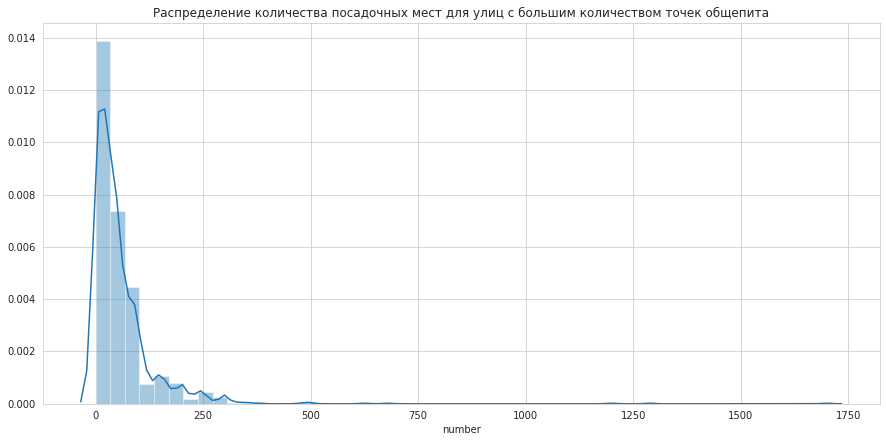

In [25]:
top_street_data = data.query('street.isin(@grouped_by_street.head(10).street)')

plt.figure(figsize=(15,7))
ax = sns.distplot(top_street_data.number)
ax.set_title('Распределение количества посадочных мест для улиц с большим количеством точек общепита')
plt.show()

На графике видно, что разброс по этому параметру очень велик, но основная масса значений сосредоточена в интервале от 0 до 100. Изучим этот интервал подробнее.

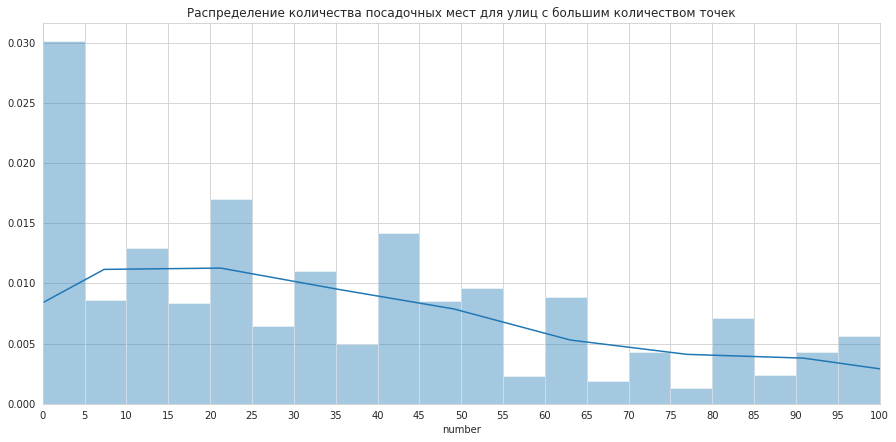

In [26]:
plt.figure(figsize=(15,7))
ax = sns.distplot(top_street_data.number, bins=340)
plt.xticks(range(0, 110, 5))
plt.xlim(0, 100)
ax.set_title('Распределение количества посадочных мест для улиц с большим количеством точек')
plt.show()

Больше всего совсем маленьких точек с числом посадочных мест менее 5. Сюда включены заведения совсем без посадочных мест -- различные стоячие кафе и кулинарии. На втором месте заведения с 20-24 местами. Заметно, что при определении числа посадочных мест владельцы заведений считают десятками.

### Выводы

Анализ данных о московском рынке общепита привел нас к следующим выводам:
* Среди заведений больше всего кафе, также довольно много столовых, ресторанов и предприятий быстрого обслуживания, а все остальные категории представлены значительно хуже.
* В московском общепите доминируют несетевые заведения, их около 81%.
* В категории сетевых заведений:
    * предприятия быстрого обслуживания вытеснили со второго места по численности столовые. В остальном картина не отличается от рынка в целом: не первом месте кафе, на третьем -- рестораны, все остальные категории сильно отстают.
    * по численности преобладают сети со сравнительно небольшим количеством точек (не более 16), в каждой из которых при этом довольно много посадочных мест (медиана -- чуть менее 50). Но из расчетов видно, что определяет лицо московского общепита не эта норма, а немногочисленные выбросы -- гиганты вроде KFC, "Шоколадницы" и "Макдональдса": по числу точек и посадочных мест они занимают 70-75% рынка.
* По количеству посадочных мест лидируют столовые (в среднем около 130 мест), за ними с отрывом примерно в 30 мест следуют рестораны, а все остальные типы заведений по этому параметру далеко позади. На третьем месте буфеты с примерно 30 посадочными местами на заведение.
* Большинство улиц, попавших в топ-10 по количеству заведений общепита, это шоссе и проспекты. Определяющую роль в распределении улиц по этому параметру играет именно их протяженность, а не расположение: лишь три улицы из топ-10 полностью или частично расположены в Центральном административном округе Москвы (меньше только в САО и СВАО), а на первом месте юг и юго-запад (по 4 улицы из первой десятки расположены в этих округах). Не представлены в топ-10 восток, юго-восток и северо-запад.
* Улиц с единственным заведением общепита в городе довольно много -- почти треть от всех улиц, на которых в принципе можно поесть. Наибольшая концентрация таких улиц наблюдается в центральных районах, где много коротких улиц и в то же время много заведений общепита, а также в Марьиной роще.
* На самых оживленных улицах каждая отдельная точка обычно очень маленькая, с числом посадочных мест менее 5. Сюда включены заведения совсем без посадочных мест -- различные стоячие кафе и кулинарии. На втором месте заведения с 20-24 местами.

Итак, кафе -- беспроигрышный вариант при выборе формата заведения для московского рынка. 

Статистика по главным торговым улицам Москвы показывает, что оптимальное количество мест -- до 5. Если по каким-то причинам нужно больше, то желательно, чтобы их было 20-24. Впрочем, это лишь эмпирические данные, которые могут объясняться и какими-то внешними обстоятельствами, например ценой аренды.

То же самое можно сказать и о выборе между сетевой или несетевой моделью: в Москве более популярна вторая, но есть вероятность, что это не реакция на спрос, а следствие других обстоятельств, например размера стартового капитала.

Если исходить из того, что распределение заведений общественного питания в пространстве объясняется уровнем платежеспособного спроса, то новое кафе или ресторан лучше всего открывать там, где заведений уже и так много (в южных или юго-западных районах). Но в этом случае надо быть готовым к высокой конкуренции. Можно пойти другим путем и постараться угадать потребности жителей восточной части города, где заведений относительно мало.

Презентация: https://docs.google.com/presentation/d/12Q946VF2bIecLMI3kBysP9jX9ooB1aG6mQnYyMLkEB4/edit?usp=sharing